# 02 - Análisis Exploratorio de Datos (EDA)

En este notebook realizaremos un EDA exhaustivo pensado para el proyecto de scoring crediticio (GiveMeSomeCredit). Contiene: carga de los datasets, resumenes estadísticos, detección de valores faltantes y outliers, análisis de correlaciones y una reducción dimensional exploratoria (PCA / t-SNE).

## Índice y estructura del EDA

Este notebook está estructurado para seguir una secuencia profesional y reproducible:

1. Carga y revisión general del dataset
2. Análisis de valores faltantes y tipos de variables
3. Distribuciones y outliers (variables numéricas)
4. Distribuciones y frecuencias (variables discretas / categóricas)
5. Análisis de correlaciones y colinealidad
6. Relaciones con la variable objetivo (`SeriousDlqin2yrs`)
7. Conclusiones e insights


In [ ]:
# Librerías básicas para el EDA
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from scipy.stats import skew
from sklearn.feature_selection import mutual_info_classif
import warnings

sns.set(style='whitegrid', rc={'figure.figsize':(8,4)})
%matplotlib inline
warnings.filterwarnings('ignore')
# Asegurar que existan las carpetas reports/data en el proyecto (raíz fija del workspace)
# para que los artefactos se guarden en C:\MachineLearningPG
ROOT = r'C:\MachineLearningPG'
DATA_DIR = os.path.join(ROOT, 'data')
REPORTS_DIR = os.path.join(ROOT, 'reports')
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)


In [ ]:
# Configuración visual global: paleta sobria (vinotinto)
paleta = ['#2b0b26', "#381723", "#af0a0a", '#d97b7b', '#f2c6c6']
sns.set_palette(paleta)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9
print('Estilo global configurado: paleta vinotinto y visuales sobrios')


Estilo global configurado: paleta vinotinto y visuales sobrios


### Helpers

Funciones reutilizables para imputación, detección de outliers y plots ordenados

In [91]:
def resumen_missing(df):
    m = df.isna().sum().sort_values(ascending=False)
    m = m[m>0]
    pct = (m / len(df) * 100).round(3)
    return pd.concat([m, pct], axis=1, keys=['n_missing','pct_missing'])

def iqr_outliers_counts(df, cols=None):
    cols = cols if cols is not None else df.select_dtypes(include=[np.number]).columns.tolist()
    out = {}
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        out[c] = int(((df[c] < lower) | (df[c] > upper)).sum())
    return pd.Series(out).sort_values(ascending=False)

def clip_or_log(df, col, method='log1p', clip_pct=0.99):
    if method=='log1p':
        return np.log1p(df[col].clip(upper=df[col].quantile(clip_pct)))
    else:
        return df[col].clip(upper=df[col].quantile(clip_pct))

def save_fig(fig, name):
    path = os.path.join(REPORTS_DIR, name)
    fig.savefig(path, dpi=150, bbox_inches='tight')
    print('Guardada figura en', path)

print('Helpers de EDA cargados: resumen_missing, iqr_outliers_counts, clip_or_log, save_fig')


Helpers de EDA cargados: resumen_missing, iqr_outliers_counts, clip_or_log, save_fig


### Cargamos los datasets

In [92]:
train_path = r'C:\MachineLearningPG\Recursos\cs-training.csv'
test_path = r'C:\MachineLearningPG\Recursos\cs-test.csv'

import pathlib
if not pathlib.Path(train_path).exists():
    raise SystemExit(f"No se encontró el archivo de entrenamiento en {train_path}. Asegúrate de que existe.")

trainingData = pd.read_csv(train_path, index_col=0)
if pathlib.Path(test_path).exists():
    testData = pd.read_csv(test_path, index_col=0)
else:
    testData = None

print('Dimensiones train:', trainingData.shape)
if testData is not None:
    print('Dimensiones test:', testData.shape)


Dimensiones train: (150000, 11)
Dimensiones test: (101503, 11)


## Diccionario de Variables:

In [93]:
trainingData.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [94]:
trainingData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

| Nombre de la Variable | Descripción | Tipo de Dato |
| --- | --- | --- |
| **SeriousDlqin2yrs** | Indica si la persona ha experimentado 90 días de morosidad o más. | Booleano (Sí/No) |
| **RevolvingUtilizationOfUnsecuredLines** | Saldo total en tarjetas de crédito y líneas de crédito personales (excepto bienes raíces y deudas a plazos como préstamos para automóviles) dividido por la suma de los límites de crédito. | Porcentaje |
| **age** | Edad del prestatario en años. | Entero |
| **NumberOfTime30-59DaysPastDueNotWorse** | Número de veces que el prestatario ha tenido un retraso en el pago de 30 a 59 días, pero no peor, en los últimos 2 años. | Entero |
| **DebtRatio** | Pagos mensuales de deudas, pensión alimenticia y costos de vida, divididos por el ingreso bruto mensual. | Porcentaje |
| **MonthlyIncome** | Ingreso mensual. | Numérico (Real) |
| **NumberOfOpenCreditLinesAndLoans** | Número de préstamos abiertos (como préstamos para automóviles o hipotecas) y líneas de crédito (por ejemplo, tarjetas de crédito). | Entero |
| **NumberOfTimes90DaysLate** | Número de veces que el prestatario se ha retrasado 90 días o más en un pago. | Entero |
| **NumberRealEstateLoansOrLines** | Número de préstamos hipotecarios y de bienes raíces, incluyendo líneas de crédito sobre el valor líquido de la vivienda. | Entero |
| **NumberOfTime60-89DaysPastDueNotWorse** | Número de veces que el prestatario ha tenido un retraso en el pago de 60 a 89 días, pero no peor, en los últimos 2 años. | Entero |
| **NumberOfDependents** | Número de dependientes en la familia, excluyendo al propio prestatario (cónyuge, hijos, etc.). | Entero |

#  Conteo y Tratamiento de valores Nulos.

In [95]:
# Nulos
missing = trainingData.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_df = pd.DataFrame({'Valores faltantes': missing, 'Porcentaje': 100 * missing / len(trainingData)})
missing_df

,Valores faltantes,Porcentaje
MonthlyIncome,29731,19.820667
NumberOfDependents,3924,2.616000


Hay 150,000 filas y 11 características en nuestros datos.
De los cuales observamos que en las columnas MonthlyIncome y NumberOfDependents hay algunos valores nulos.

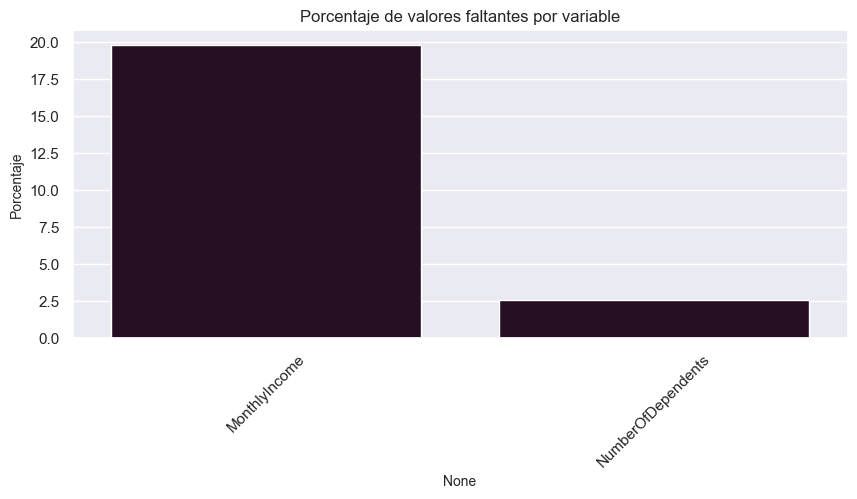

In [96]:
# Visualización de valores faltantes
plt.figure(figsize=(10,4))
sns.barplot(x=missing_df.index, y=missing_df['Porcentaje'])
plt.xticks(rotation=45)
plt.title('Porcentaje de valores faltantes por variable')
plt.show()

Tratamiento de nulos: en este caso, usaremos la mediana para MonthlyIncome y el valor más frecuente (moda) para NumberOfDependents.

In [97]:
trainingData['MonthlyIncome'].fillna(trainingData['MonthlyIncome'].median(), inplace=True)
trainingData['NumberOfDependents'].fillna(0, inplace = True)

Verificamos que ya no hayan nulos.

In [98]:
# Nulos
missing = trainingData.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_df = pd.DataFrame({'Valores faltantes': missing, 'Porcentaje': 100 * missing / len(trainingData)})
missing_df
if missing_df.empty:
    print("Variables con valores faltantes:")
    print(None)

Variables con valores faltantes:
None


## Análisis de outliers (regresión contra la variable objetivo e IQR)

Resumen visual y numérico de outliers usando IQR y visualizaciones de regplot (muestreo para no plotear todo el dataset).


,Variable,Outliers,%
4,DebtRatio,31311,20.874000
3,NumberOfTime30-59DaysPastDueNotWorse,23982,15.988000
10,NumberOfDependents,13336,8.890667
0,SeriousDlqin2yrs,10026,6.684000
5,MonthlyIncome,9149,6.099333
7,NumberOfTimes90DaysLate,8338,5.558667
9,NumberOfTime60-89DaysPastDueNotWorse,7604,5.069333
6,NumberOfOpenCreditLinesAndLoans,3980,2.653333
8,NumberRealEstateLoansOrLines,793,0.528667
1,RevolvingUtilizationOfUnsecuredLines,763,0.508667


✓ Resumen de outliers guardado en: C:\MachineLearningPG\reports\outlier_summary_train.csv


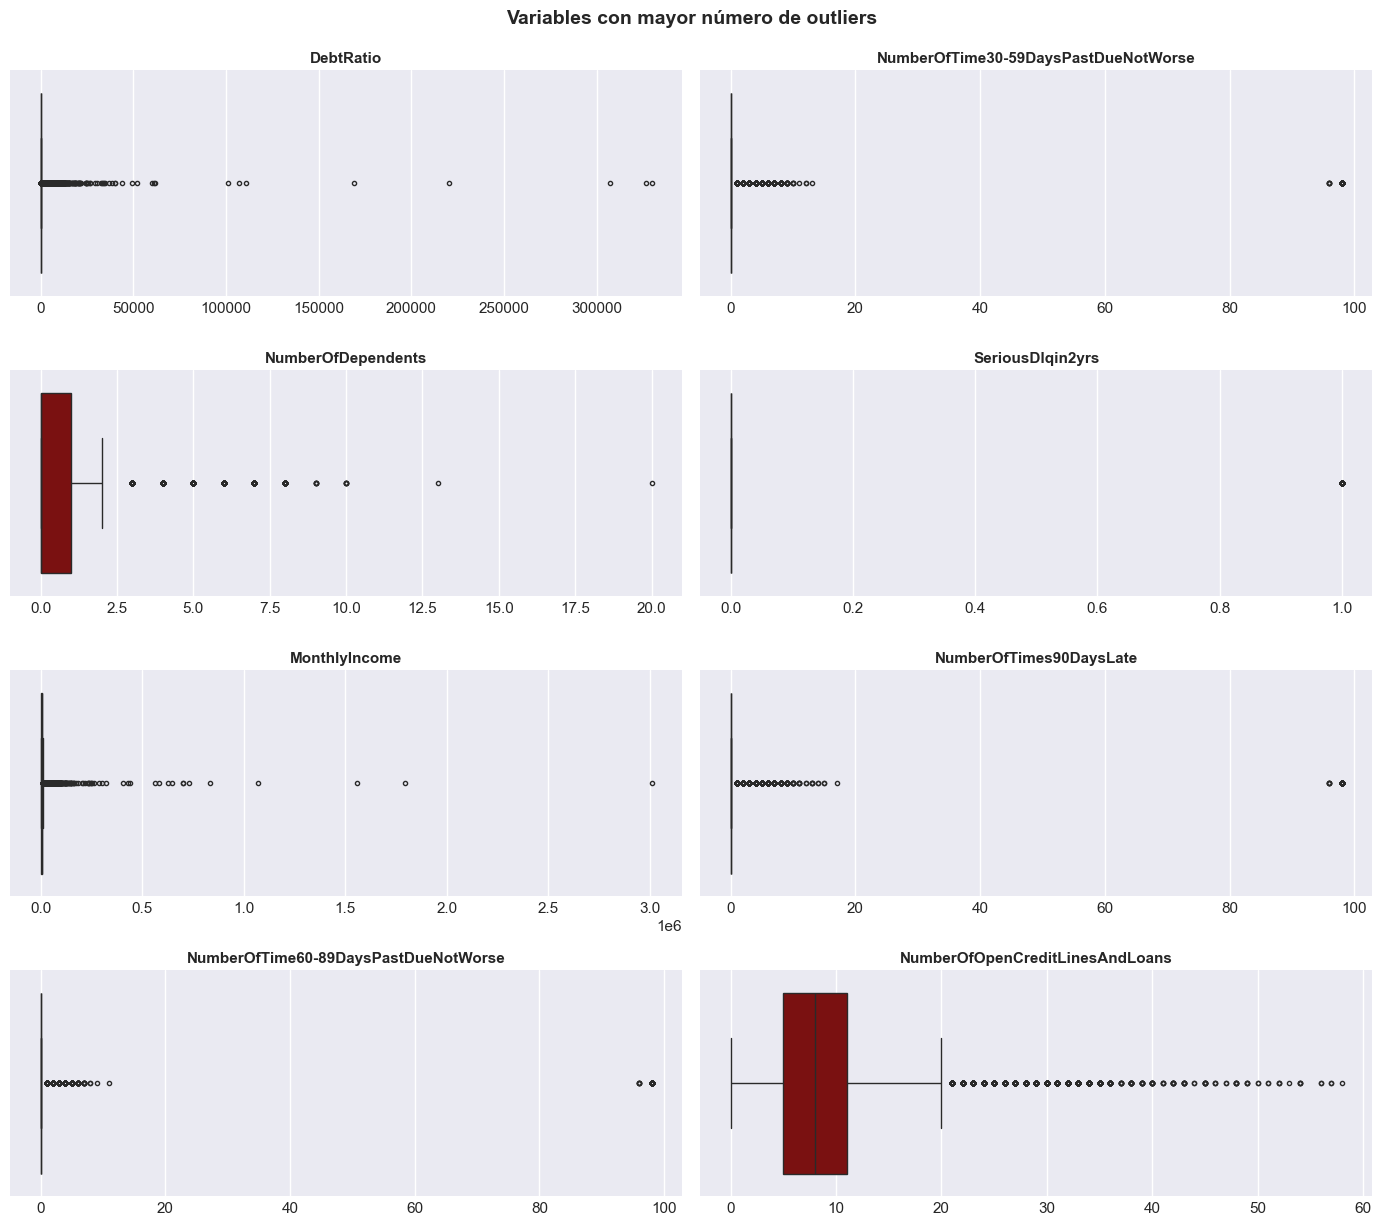

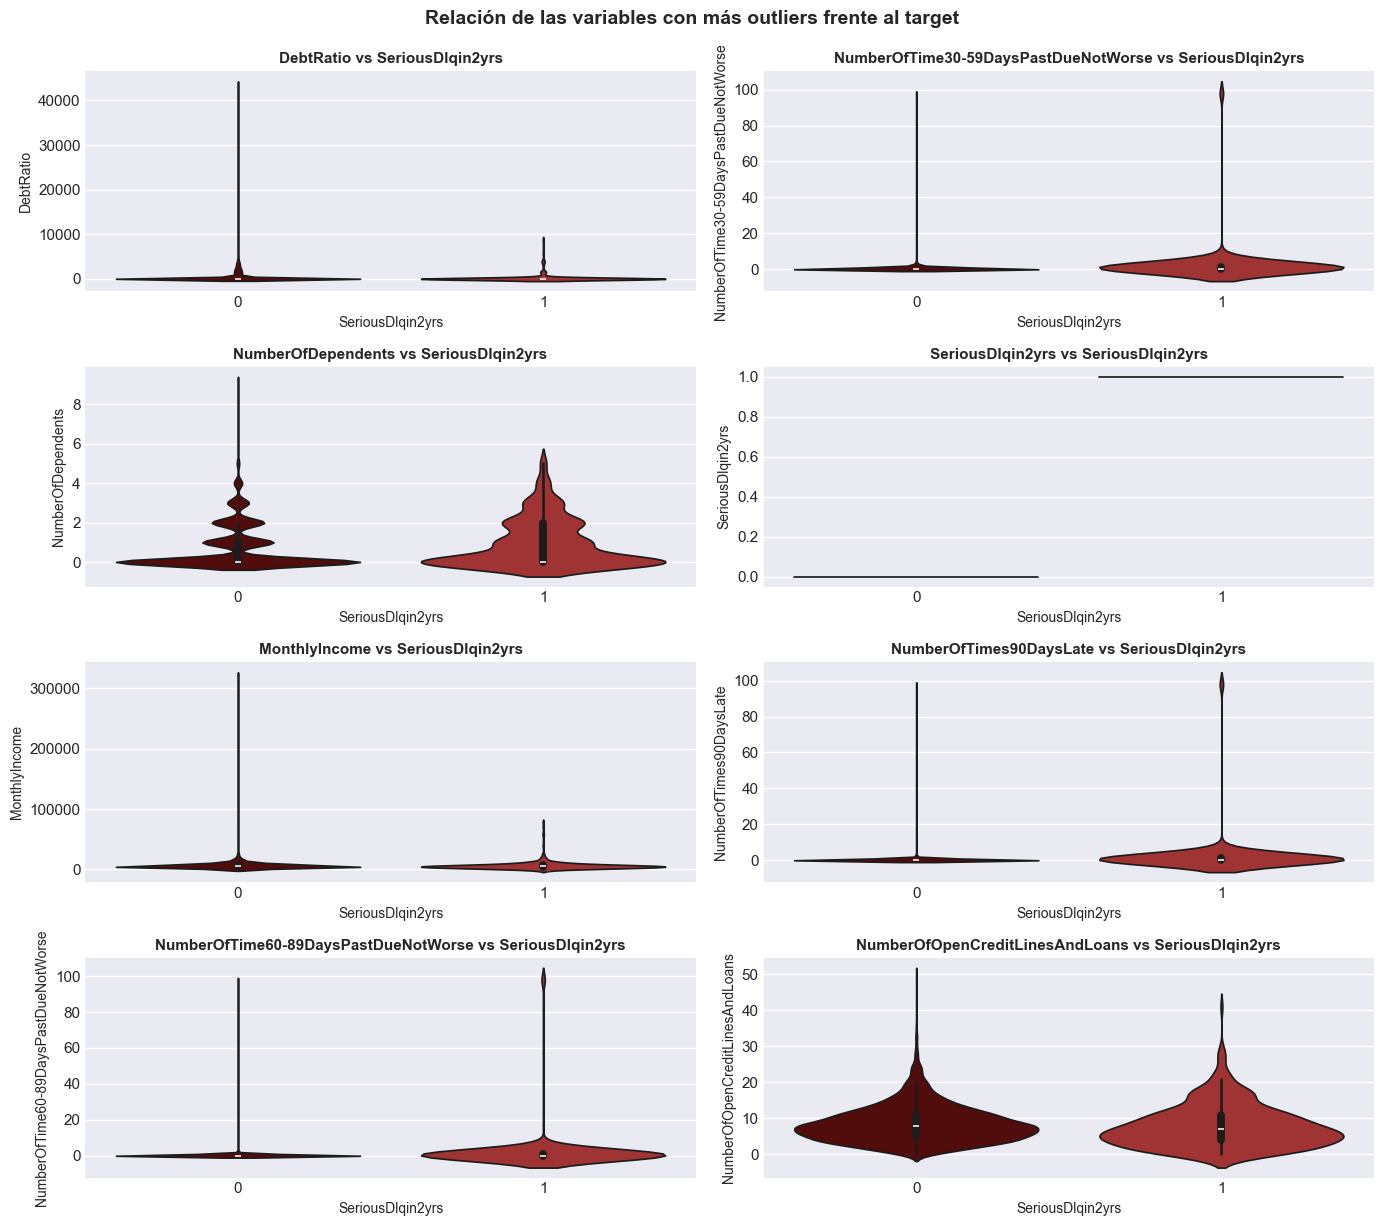

In [ ]:
# Análisis de Outliers (IQR)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('dark:#8B0000') 

num_cols = trainingData.select_dtypes(include=[np.number]).columns.tolist()
iqr_summary = []

for col in num_cols:
    q1, q3 = trainingData[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = ((trainingData[col] < lower) | (trainingData[col] > upper)).sum()
    perc = outliers / len(trainingData) * 100
    iqr_summary.append([col, outliers, perc])

iqr_df = pd.DataFrame(iqr_summary, columns=['Variable', 'Outliers', '%'])
iqr_df = iqr_df.sort_values(by='Outliers', ascending=False)
display(iqr_df.head(10))

# Guardar resumen
out_path = os.path.join(REPORTS_DIR, 'outlier_summary_train.csv')
iqr_df.to_csv(out_path, index=False)
print(f'✓ Resumen de outliers guardado en: {out_path}')

# Visualización de las 8 variables más afectadas
top_outliers = iqr_df.head(8)['Variable']
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, col in zip(axes, top_outliers):
    sns.boxplot(x=trainingData[col], ax=ax, color='#8B0000', fliersize=3)
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_xlabel('')
plt.tight_layout()
plt.suptitle('Variables con mayor número de outliers', fontsize=14, y=1.02, fontweight='bold')
plt.show()

# Relaciones con el target
sampled = trainingData.sample(min(6000, len(trainingData)), random_state=42)
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, col in zip(axes, top_outliers):
    try:
        sns.violinplot(x='SeriousDlqin2yrs', y=col, data=sampled, ax=ax, palette=['#5C0000', '#B22222'])
        ax.set_title(f'{col} vs SeriousDlqin2yrs', fontsize=11, fontweight='bold')
    except Exception as e:
        ax.text(0.5, 0.5, f'Error en {col}', ha='center')
plt.tight_layout()
plt.suptitle('Relación de las variables con más outliers frente al target', fontsize=14, y=1.02, fontweight='bold')
plt.show()


# Interpretación general
 **Insights sobre outliers y su relación con el target**

- Las variables financieras como `DebtRatio` y `MonthlyIncome` presentan valores extremadamente altos que podrían distorsionar las métricas de los modelos.
- Variables de comportamiento crediticio (`NumberOfTimes90DaysLate`, `NumberOfTime60-89DaysPastDueNotWorse`) muestran valores atípicos elevados y concentraciones cerca de cero, indicando una fuerte asimetría.
- Los individuos con valores altos en estas variables tienden a tener mayor probabilidad de incumplimiento (`SeriousDlqin2yrs = 1`), lo que sugiere un patrón de riesgo claro.
- La variable `NumberOfDependents` tiene algunos valores atípicos inusualmente altos (>10), posiblemente errores o casos raros que convendría revisar.


# Distribuciones

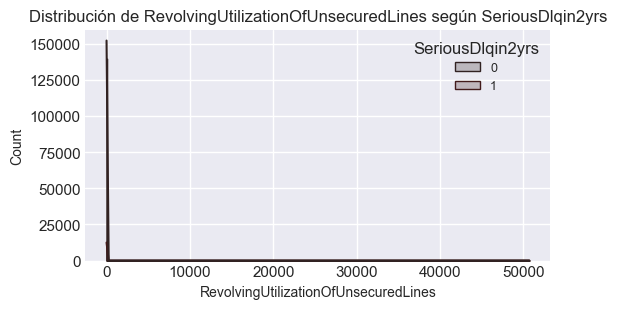

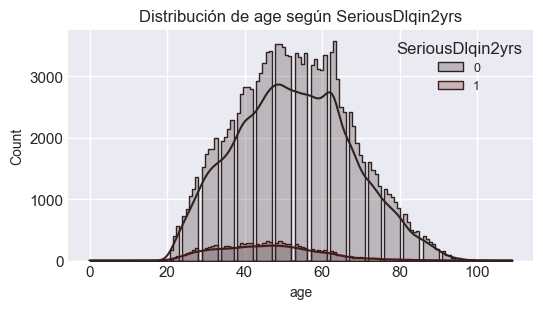

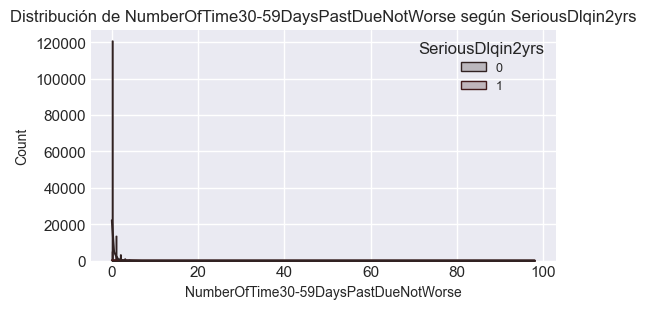

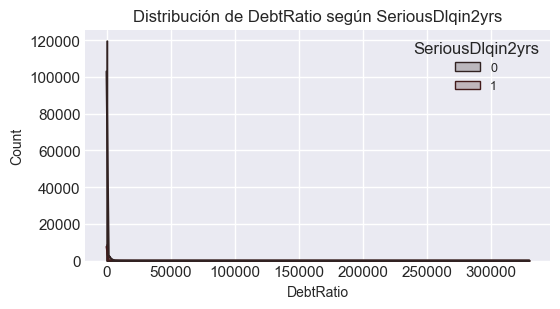

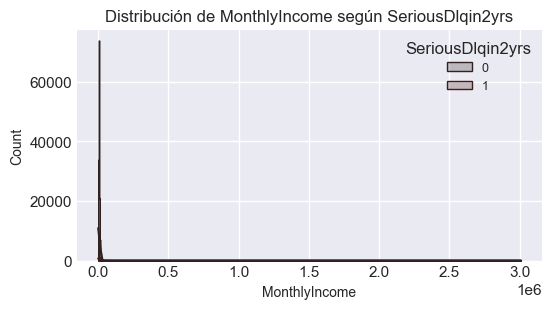

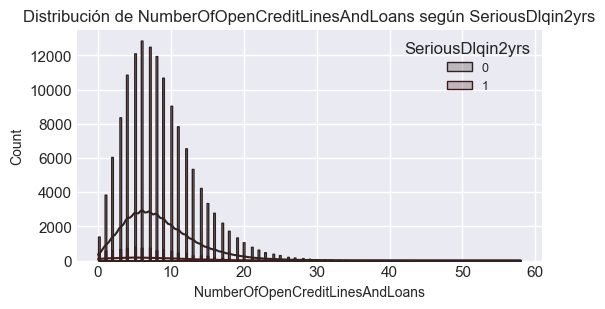

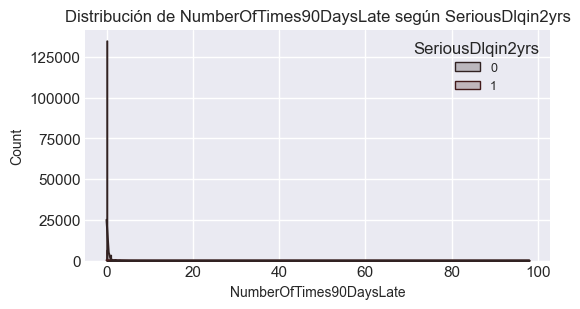

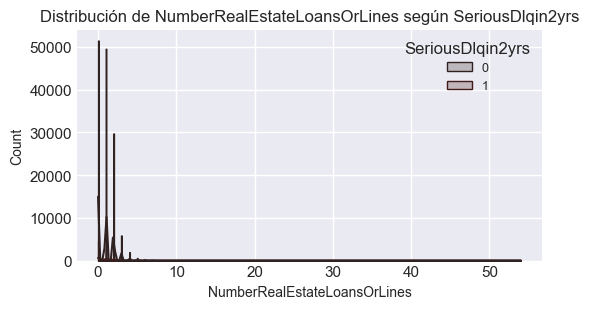

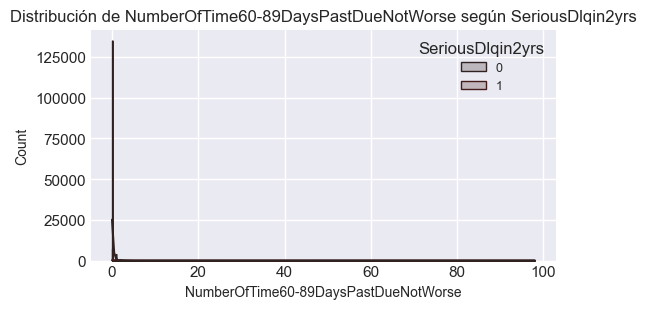

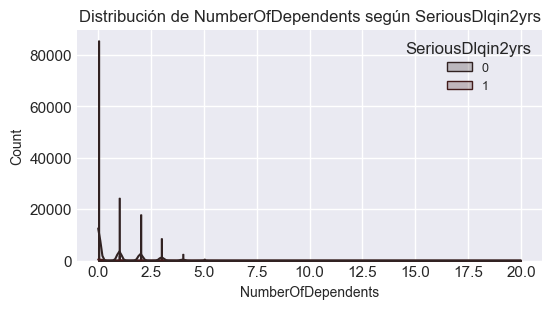

In [ ]:
def plot_distributions_continuous(df, target):
    cont_cols = [col for col in df.select_dtypes(include=np.number).columns if col != target]
    for col in cont_cols:
        plt.figure(figsize=(6,3))
        sns.histplot(data=df, x=col, hue=target, kde=True, element='step')
        plt.title(f"Distribución de {col} según {target}")
        plt.show()

plot_distributions_continuous(trainingData, 'SeriousDlqin2yrs')

## Ratio de clases y visualizaciones básicas

Mostrar la proporción de clases (pie y countplot) y guardar la figura en `reports/`.

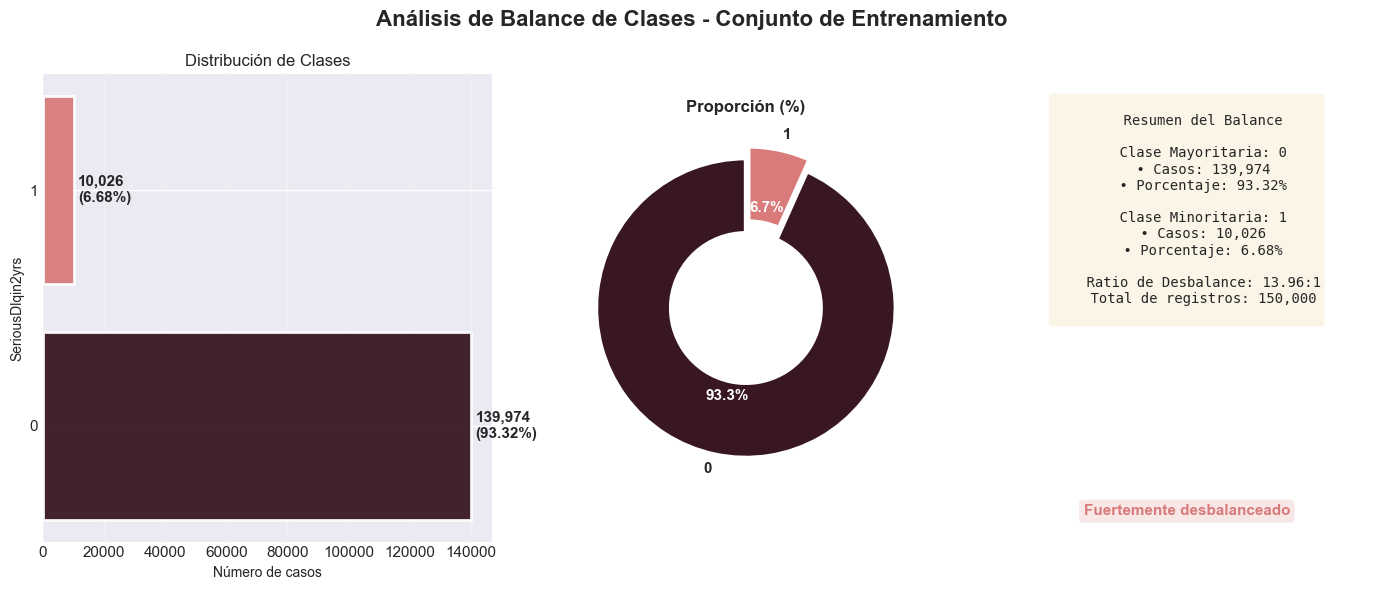

✓ Figura de ratio de clases guardada en: C:\MachineLearningPG\reports\imbalance_ratio_train.png


In [ ]:
# Estilo moderno
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette(paleta)

if 'SeriousDlqin2yrs' in trainingData.columns:
    counts = trainingData['SeriousDlqin2yrs'].value_counts()
    total = len(trainingData)
    percentages = (counts / total * 100).round(2)
    colors = [paleta[1], paleta[3]]
    # Crear figura
    fig = plt.figure(figsize=(14, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.2, 1, 1])
    
    ax1 = fig.add_subplot(gs[0, 0])
    bars = ax1.barh(counts.index.astype(str), counts.values, color=colors, 
                    edgecolor='white', linewidth=2, alpha=0.95)
    for bar, count, pct in zip(bars, counts.values, percentages.values):
        ax1.text(bar.get_width() + total * 0.01, bar.get_y() + bar.get_height()/2,
                 f'{count:,}\n({pct}%)', va='center', ha='left', fontweight='bold', fontsize=11)
    ax1.set(xlabel='Número de casos', ylabel='SeriousDlqin2yrs', 
            title='Distribución de Clases')
    ax1.spines[['top','right']].set_visible(False)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    
    ax2 = fig.add_subplot(gs[0, 1])
    wedges, _, autotexts = ax2.pie(counts.values, labels=counts.index, autopct='%1.1f%%',
                                   colors=colors, startangle=90, explode=[0, 0.08],
                                   wedgeprops=dict(width=0.5, edgecolor='white', linewidth=3),
                                   textprops=dict(fontweight='bold', fontsize=11))
    for autotext in autotexts: autotext.set_color('white')
    ax2.set_title('Proporción (%)', fontweight='bold')
    
    ax3 = fig.add_subplot(gs[0, 2]); ax3.axis('off')
    ratio = counts.max() / counts.min()
    majority, minority = counts.idxmax(), counts.idxmin()
    
    balance_map = [(10, 'Fuertemente desbalanceado', paleta[3]),
                   (3, 'Moderadamente desbalanceado', paleta[2])]
    status, color = next(((s, c) for t, s, c in balance_map if ratio > t),
                         ('Relativamente balanceado', paleta[0]))
    
    info_text = f"""
    Resumen del Balance

    Clase Mayoritaria: {majority}
    • Casos: {counts[majority]:,}
    • Porcentaje: {percentages[majority]:.2f}%

    Clase Minoritaria: {minority}
    • Casos: {counts[minority]:,}
    • Porcentaje: {percentages[minority]:.2f}%

    Ratio de Desbalance: {ratio:.2f}:1
    Total de registros: {total:,}
    """
    ax3.text(0.5, 0.95, info_text, transform=ax3.transAxes,
             fontsize=10, va='top', ha='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
             family='monospace')
    ax3.text(0.5, 0.05, status, transform=ax3.transAxes,
             fontsize=11, fontweight='bold', va='bottom', ha='center',
             color=color, bbox=dict(boxstyle='round', facecolor=color, alpha=0.18))
    
    plt.suptitle('Análisis de Balance de Clases - Conjunto de Entrenamiento', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    fig_path = os.path.join(REPORTS_DIR, 'imbalance_ratio_train.png')
    plt.savefig(fig_path, dpi=200, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f'✓ Figura de ratio de clases guardada en: {fig_path}')

else:
    print('No se encontró la columna objetivo; se omite la visualización de ratio de clases.')

### Uso del crédito vs probabilidad de impago

Este histograma muestra la distribución del uso del crédito y cómo se relaciona con la probabilidad de impago.

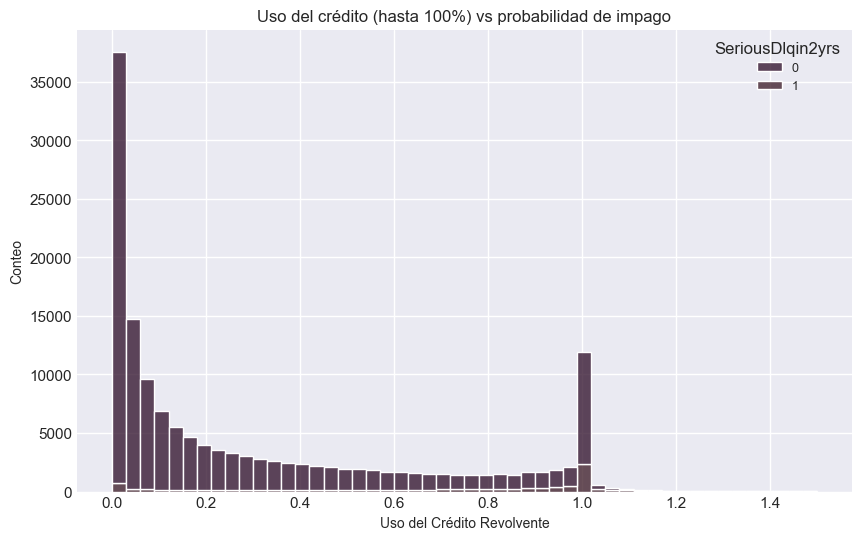

In [102]:
# Hacemos una copia para no modificar el dataframe original
data_filtrada = trainingData.copy()

# Filtramos para mantener solo los valores menores o iguales a 1 (100% de utilización)
data_filtrada = data_filtrada[data_filtrada['RevolvingUtilizationOfUnsecuredLines'] <= 1.5]

# Creamos el gráfico con los datos filtrados y más bins para mayor detalle
plt.figure(figsize=(10, 6)) # Hacemos el gráfico un poco más grande
sns.histplot(data=data_filtrada, x='RevolvingUtilizationOfUnsecuredLines', hue='SeriousDlqin2yrs', 
             multiple="stack", # Apila las barras para ver mejor la proporción
             bins=50) # Aumentamos el número de bins para ver más detalle

plt.title("Uso del crédito (hasta 100%) vs probabilidad de impago")
plt.xlabel("Uso del Crédito Revolvente")
plt.ylabel("Conteo")
plt.show()

Y el gráfico nos demuestra de forma efectiva que existe una fuerte correlación positiva entre el nivel de utilización del crédito y la probabilidad de incurrir en una morosidad grave.
A medida que te desplazamos de izquierda a derecha en el gráfico (es decir, a medida que aumenta el uso del crédito), la proporción de la barra que corresponde al impago (SeriousDlqin2yrs = 1, el color más rojizo) se hace cada vez más grande.

### Número de Dependientes vs Probabilidad de Impago

Text(0, 0.5, 'Probabilidad de Impago')

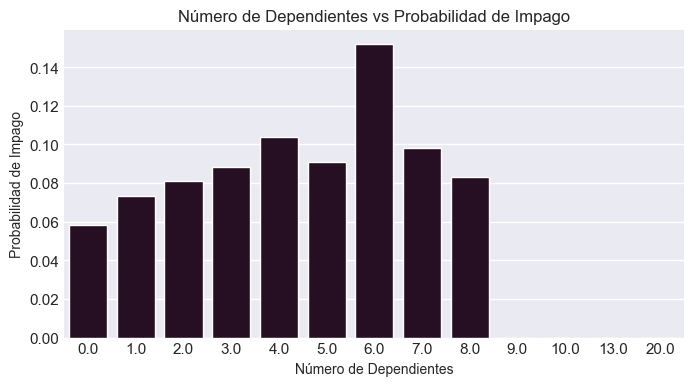

In [109]:
sns.barplot(x='NumberOfDependents', y='SeriousDlqin2yrs', data= trainingData, ci=None)
plt.title('Número de Dependientes vs Probabilidad de Impago')
plt.xlabel('Número de Dependientes')
plt.ylabel('Probabilidad de Impago')

Tal parece que el número de dependientes puede ser un factor importante para predecir el riesgo de impago. El riesgo tiende a aumentar con el número de personas a cargo, pero alcanza un punto crítico en 6 dependientes, para luego disminuir. Esto podría ser un punto clave para un modelo de riesgo crediticio.

### Ingreso Mensual vs Probabilidad de Impago


Este diagrama de cajas (box plot) compara la distribución del ingreso mensual para dos grupos de personas:
- Grupo 0: Aquellos que no incurrieron en impago en los últimos 2 años.
- Grupo 1: Aquellos que sí incurrieron en impago en los últimos 2 años

Decidimos cortar en un percentil, escpecificamente el 99%. Esto significa que eliminaremos del gráfico el 1% de las personas con los ingresos más altos para poder ver con mayor claridad la distribución del 99% restante.

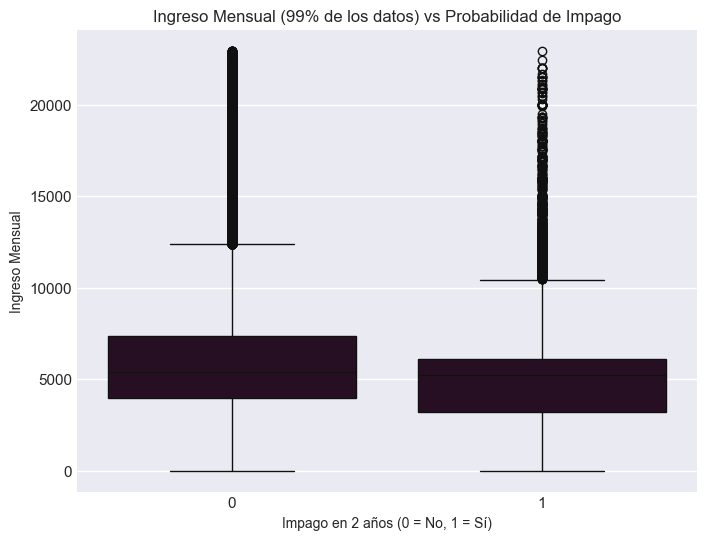

In [112]:
# Filtra los datos para visualizar el 99% de los ingresos
income_limite = trainingData['MonthlyIncome'].quantile(0.99)
data_filtrada = trainingData[trainingData['MonthlyIncome'] < income_limite]

# Crea el gráfico
plt.figure(figsize=(8, 6))
sns.boxplot(x='SeriousDlqin2yrs', y='MonthlyIncome', data=data_filtrada)
plt.title("Ingreso Mensual (99% de los datos) vs Probabilidad de Impago")
plt.xlabel("Impago en 2 años (0 = No, 1 = Sí)")
plt.ylabel("Ingreso Mensual")
plt.show()

Este gráfico confirma de manera efectiva que el ingreso mensual es un indicador importante del riesgo crediticio. Un menor ingreso está asociado con una mayor probabilidad de que una persona enfrente dificultades para cumplir con sus obligaciones de pago.

---
### Correlación y Colinealidad


A continuación, se realizará un análisis para entender las relaciones entre las variables. Primero, se generará una **matriz de correlación** para identificar la multicolinealidad, es decir, la redundancia entre las características predictoras. Inmediatamente después, se calculará la **Información Mutua** para medir la fuerza de la relación (lineal y no lineal) de cada característica con la variable objetivo `SeriousDlqin2yrs`. Este doble análisis es fundamental para seleccionar las variables más predictivas y descartar las redundantes, un paso clave para la construcción de un modelo de machine learning eficaz.

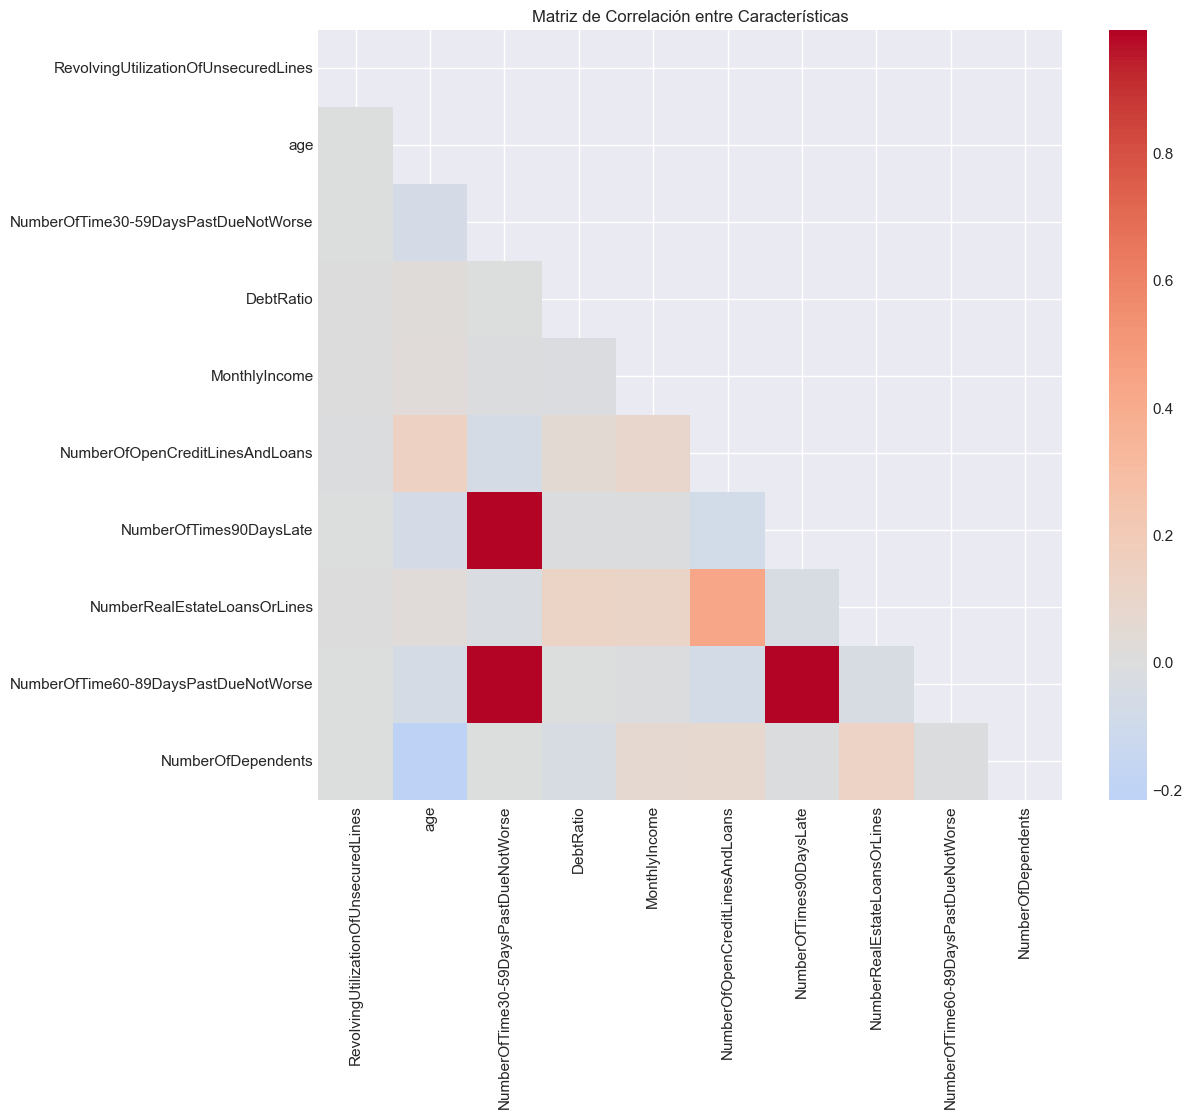

Pares de variables con alta correlación (> 0.7):


,Variable 1,Variable 2,Correlación Absoluta
86,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,0.992796
68,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,0.992796
82,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse,0.987005
28,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,0.987005
26,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,0.983603
62,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse,0.983603



Información Mutua de cada característica con la variable objetivo:


RevolvingUtilizationOfUnsecuredLines    0.036152
NumberOfTimes90DaysLate                 0.031424
NumberOfTime30-59DaysPastDueNotWorse    0.026458
NumberOfTime60-89DaysPastDueNotWorse    0.021728
age                                     0.007740
NumberRealEstateLoansOrLines            0.006448
NumberOfOpenCreditLinesAndLoans         0.005830
DebtRatio                               0.004010
MonthlyIncome                           0.003648
NumberOfDependents                      0.003343
dtype: float64

In [ ]:
# Matriz de Correlación
num_cols = trainingData.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('SeriousDlqin2yrs')

corr = trainingData[num_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool)) # Máscara para el triángulo superior
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=False)
plt.title('Matriz de Correlación entre Características')
plt.show()

# Identifica y muestra pares con correlación > 0.7 para revisar multicolinealidad
high_corr = corr.abs().stack().reset_index()
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlación Absoluta']
# Elimina la auto-correlación (diagonal)
high_corr = high_corr[high_corr['Variable 1'] != high_corr['Variable 2']]
# Ordena y muestra los más altos
high_corr = high_corr[high_corr['Correlación Absoluta'] > 0.7].sort_values(by='Correlación Absoluta', ascending=False)

print("Pares de variables con alta correlación (> 0.7):")
display(high_corr)

# Calcula qué tan informativa es cada variable para predecir 'SeriousDlqin2yrs'
X_mi = trainingData[num_cols]
y_mi = trainingData['SeriousDlqin2yrs']

mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42)
mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=False)

print("\nInformación Mutua de cada característica con la variable objetivo:")
display(mi_series)

#### Alta Correlación entre Variables

En el análisis de la matriz de correlación, se identificó un problema de **multicolinealidad** casi perfecta entre las siguientes tres variables:

*   `NumberOfTime30-59DaysPastDueNotWorse`
*   `NumberOfTime60-89DaysPastDueNotWorse`
*   `NumberOfTimes90DaysLate`

La correlación entre ellas superaba el **0.98**, lo que indica que son altamente redundantes. Estas variables miden esencialmente el mismo comportamiento subyacente: la tendencia de un cliente a retrasarse en sus pagos.

#### Solución Adoptada: Selección de la Característica más Predictiva

Para resolver este problema, se decidió adoptar una estrategia de selección de características en lugar de combinarlas. La estrategia consiste en **conservar únicamente la variable que aporte más información predictiva sobre el impago y descartar las otras dos.**

Para determinar cuál era la más predictiva, se utilizó el análisis de **Información Mutua**, el cual nos indicó el poder predictivo de cada variable con respecto a nuestro objetivo `SeriousDlqin2yrs`. Aunque las tres variables mostraron una alta capacidad predictiva, se seleccionó `NumberOfTimes90DaysLate` por dos razones clave:

1.  **Alto Poder Predictivo:** Se encuentra entre las variables con mayor puntuación de Información Mutua.
2.  **Severidad del Indicador:** Un retraso de 90 días o más es, por definición, un indicador de morosidad más grave y, por lo tanto, conceptualmente más fuerte para predecir un impago serio.

#### Resultados de la Acción

Como resultado de este análisis, se procederá a modificar el conjunto de datos de la siguiente manera:

*   **Variable Conservada:** `NumberOfTimes90DaysLate`
*   **Variables a despreciar:**
    *   `NumberOfTime30-59DaysPastDueNotWorse`
    *   `NumberOfTime60-89DaysPastDueNotWorse`

Con esta acción, eliminamos la redundancia de datos, simplificamos el modelo y nos aseguramos de que las variables predictoras sean más independientes entre sí, lo que conducirá a un modelo más robusto e interpretable.


## Reducción dimensional exploratoria: PCA y (opcional) t-SNE

Realizaremos PCA sobre las variables numéricas escaladas y mostraremos los dos primeros componentes. Si se desea, se puede añadir t-SNE en un paso posterior para visualizar estructuras no lineales.

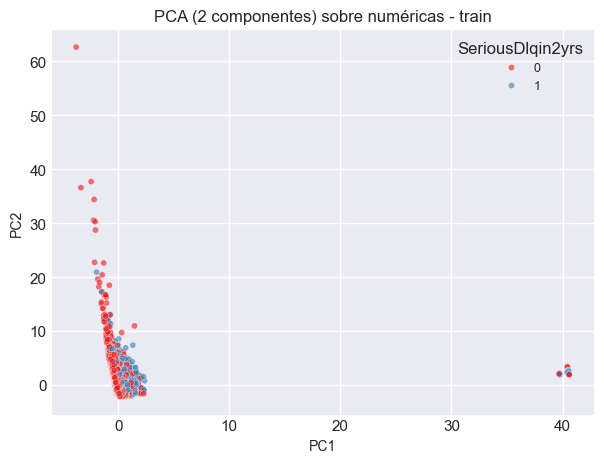

Varianza explicada por componente: [0.29950034 0.15374301]


In [ ]:
# PCA sobre variables numéricas (tras escalado) - train
if len(num_cols) > 1:
    X = trainingData[num_cols].dropna()  # PCA simple: descartar filas con NA en numéricas
    idx = X.index
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    pca = PCA(n_components=2, random_state=42)
    comps = pca.fit_transform(Xs)
    plt.figure(figsize=(7,5))
    target = 'SeriousDlqin2yrs'
    if target in trainingData.columns:
        lab = trainingData.loc[idx, target]  # alineo etiquetas con X
        sns.scatterplot(x=comps[:,0], y=comps[:,1], hue=lab, palette='Set1', alpha=0.6, s=20)
        plt.legend(title=target)
    else:
        plt.scatter(comps[:,0], comps[:,1], s=10, alpha=0.6)
    plt.title('PCA (2 componentes) sobre numéricas - train')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
    print('Varianza explicada por componente:', pca.explained_variance_ratio_)
else:    print('No hay suficientes columnas numéricas para PCA.')

### Conclusión del Análisis de Componentes Principales (PCA)

Para obtener una visión general de la estructura de los datos, se aplicó un Análisis de Componentes Principales (PCA). El objetivo era reducir la dimensionalidad de todas las características numéricas a solo dos componentes (PC1 y PC2) para visualizar si existía una separación natural entre los clientes que incurren en impago (`SeriousDlqin2yrs = 1`) y los que no (`SeriousDlqin2yrs = 0`).

**Resultados Clave:**

1.  **Varianza Explicada Limitada:** Los resultados numéricos mostraron que los dos componentes principales capturan una porción limitada de la información total.
    *   **PC1 (eje X):** Explica el **29.9%** de la varianza.
    *   **PC2 (eje Y):** Explica el **15.4%** de la varianza.
    En conjunto, esto significa que esta visualización 2D solo representa el **45% de la información total** contenida en los datos. La complejidad del problema no puede ser simplificada a solo dos dimensiones.

2.  **Falta de Separabilidad Lineal:** El gráfico de dispersión muestra una **fuerte superposición** entre las dos clases. Los puntos que representan a los clientes que incurrieron en impago (en azul) y los que no (en rojo) están en su mayoría mezclados, sin una frontera clara que los separe.

**Conclusión Final:**

La principal conclusión de este análisis es que la distinción entre los clientes que pagan a tiempo y los que no, es sutil y compleja. **No existe una combinación lineal simple de las características que pueda separar eficazmente las dos clases**. Esto refuerza la necesidad de utilizar modelos de machine learning capaces de capturar relaciones no lineales y subraya la importancia de la selección de características individuales, como se vio previamente con la Información Mutua.